# Summary

In this notebook, I play with the pre-trained model: Faster RCNN. (Procedure is the same for Mask RCNN)

These models are from facebook AI research. About Detectron2: is FAIR's next-generation platform for object detection and segmentation.

I will do the following from this notebook:

1. how to load and the pretrained model.
2. how to use the model to make class activation map (CAM) for an image.


References:

1. detectron2: https://github.com/facebookresearch/detectron2
2. documentation: https://detectron2.readthedocs.io/tutorials/getting_started.html
2. rareplane dataset: https://github.com/aireveries/RarePlanes

# Install detectron2

In [1]:
# install dependencies: 
!pip install pyyaml==5.1 'pycocotools>=2.0.1'
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 5.7MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=8e784b53bb8cc7c904ffd392c0167b6283bc7fba4bb3b43e748e1a6415adb0af
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0MB 23kB/s 
     |████████████████████████████████| 5.9MB 40.4MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C)

In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 6.6MB 1.6MB/s 
     |████████████████████████████████| 2.2MB 7.0MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201111-cp36-none-any.whl size=44418 sha256=bd9438d6fe2f988b4e485249422d00d0d1adb743ff2eacf6f9e1c59ab5949853
  Stored in directory: /root/.cache/pip/wheels/70/d9/52/49a17f0d21e723c371c4a3f60138545e0a4163c5f7ff42c855
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
import torch 
import torchvision
import torch.nn as nn 
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
import PIL
import requests

# Load the pretrained model 

from RarePlane: https://github.com/aireveries/RarePlanes

In [5]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = "/content/drive/My Drive/111 Rendered.ai/rareplane_models/model_0043999.pth"

In [6]:
from detectron2.modeling import build_model
model = build_model(cfg)

In [ ]:
print(model)

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

# Spatial Attention Map

Attention paper: https://arxiv.org/abs/1612.03928 

In [ ]:
ra

# Localization Map

In [ ]:
from torchvision.models._utils import IntermediateLayerGetter

# Refer to https://github.com/pytorch/vision/blob/master/torchvision/models/_utils.py

imagenet_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
        ])

In [ ]:
# PATH
PATH = "/content/drive/My Drive/111 Rendered.ai/rendered/datasets/Airplanes/000/images/0000000005-air.png"
im = cv2.imread(PATH)

In [ ]:
im.shape

(512, 512, 3)

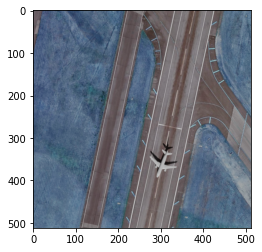

In [ ]:
plt.imshow(im)

In [ ]:
# send both the model and data to gpu
fast_rcnn = model.to(device)
X = imagenet_transform(im).unsqueeze(0).to(device)
print(f"Size of input {X.shape}")

Size of input torch.Size([1, 3, 512, 512])


## The objectness logits map at each level

In [ ]:
def objectness_logit_map():
    fast_rcnn.eval()
    feature_map = fast_rcnn.backbone(X)
    f, axarr = plt.subplots(1,5, figsize=(15,15))
    for i in range(2,7):
        feature_map_pi = feature_map["p"+str(i)]
        # print(feature_map_pi.shape)
        out = fast_rcnn.proposal_generator.rpn_head.conv(feature_map_pi)
        # print(out.shape)
        out = fast_rcnn.proposal_generator.rpn_head.objectness_logits(out)
        # print(out.shape)
        sigmoid_fn = nn.Sigmoid()
        out = sigmoid_fn(out)
        out = out[0].permute(1,2,0)
        out_ = out.cpu().detach().numpy()
        # print(out_.shape)
        axarr[i-2].imshow(out_)
        axarr[i-2].set_title("objectness on p"+str(i))

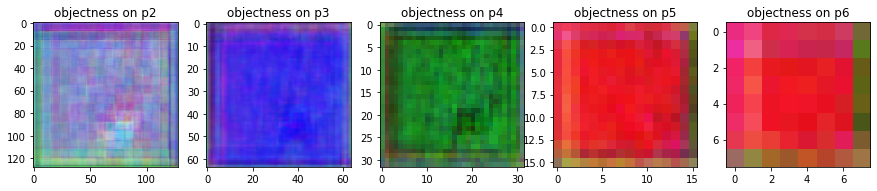

In [ ]:
objectness_logit_map()

## CAM

Disadvantage: only works for easy architectures, where there's Res + max_pooling + classification layer. But for FastRCNN, this is harder.

1. FPN: output size: (batch_size, 256, width, height)
2. Add a max pooling layer to replace the ROI network.
2. Classification layer: required input is (batch_size, 256, 7, 7) 

In [ ]:
fast_rcnn.eval()
feature_map = fast_rcnn.backbone(X)
feature_map.keys()

dict_keys(['p2', 'p3', 'p4', 'p5', 'p6'])

In [ ]:
feature_map["p2"].shape

torch.Size([1, 256, 128, 128])

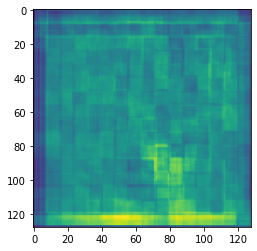

In [ ]:
plt.imshow(feature_map["p2"][0][1].cpu().detach().numpy())

In [ ]:
# get the feature map
feature_map_pi = feature_map["p5"]
print(feature_map_pi.shape)

# max pooling 
m = nn.MaxPool2d(3, stride=2)
out = m(feature_map_pi)
print(out.shape)

# classification layer
flater = fast_rcnn.roi_heads.box_head.flatten
out = flater(out)
print(out.shape)

fc_1 = fast_rcnn.roi_heads.box_head.fc1
out = fc_1(out)
out = fast_rcnn.roi_heads.box_head.fc_relu1(out)
print(out.shape)

cls = fast_rcnn.roi_heads.box_predictor.cls_score
out = cls(out)
print(out.shape)

torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 7, 7])
torch.Size([1, 12544])
torch.Size([1, 1024])
torch.Size([1, 81])


In [ ]:
softmax = nn.Softmax(dim=1)   # dim=3 represents the softmax is on the pixel. for each pixel, we take the softmax
logits = softmax(out)
print(logits.shape)

torch.Size([1, 81])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


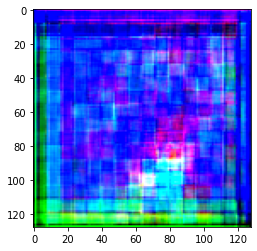

In [ ]:
out_ = out[0].permute(1,2,0)
plt.imshow(out_.cpu().detach().numpy())

#### I will get a 256 64*64 images. But what do I do with these 256 images? Simply adding them together? 

In [ ]:
def localisation(X, fast_rcnn):
    """
    Generate a localisation map for the predicted class given an input 
    image and a pretrained CNN
    
    Inputs:
    - X: Input image: synthetic data, Size of input torch.Size([1, 3, 512, 512])
    - fast_rcnn: Pretrained Fast RCNN on real data
    
    Returns:
    - localisation_map : feature map from FPN(feature pyramid network), p2-p6
    """
    fast_rcnn.eval()
    feature_map = fast_rcnn.backbone(X)
    # check output shape at each layer of the backbone.
    # print("input:", X.size())
    localisation_map = []
    
    # plot the output
    f, axarr = plt.subplots(1,5,figsize=(17,17))
    for i in range(2,7):
        feature_map_pi = feature_map["p"+str(i)][0].cpu().detach().numpy()
        axarr[i-2].imshow(feature_map_pi.sum(0))
        axarr[i-2].set_title("feature map of p"+str(i))
        
        # save res
        localisation_map.append(feature_map_pi.sum(0))
    return np.asarray(localisation_map)

    
def upsampling(p_i, local_maps, upsampling_mode='nearest'):
    """
    p_i: which pyramid in the FPN
    local_maps: a list of local_maps, which contains feature maps from p2 to p6.
    upsampling_mode: which upsampling method you choose from nn.upsample. default is 'nearest'.
    """
    p_i_to_scale_factor = {0:4, 1:8, 2:16, 3:32, 4:64}
    input = torch.from_numpy(local_maps[p_i]).view(1,1,local_maps[p_i].shape[0],-1)
    # print(input.size())
    upsampler = nn.Upsample(scale_factor=p_i_to_scale_factor[p_i], mode='nearest')
    out = upsampler(input)
    # print(out.size())
    return out


def overlay_heatmap(local_map, image, alpha=0.7, colormap=cv2.COLORMAP_JET):
    """
    input:
    cam: upsampled localization map size (512,512)
    image: orginial image (512, 512, 3) from cv2.imread()
    alpha: weights of activation map vs orginal image
    colormap: you choose 
    """

    # normalization
    heatmap = (cam -cam.min()) / (cam.max()-cam.min())

    # apply the supplied color map to the heatmap 
    CAM = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)

    # overlay the heatmap on the input image
    output = cv2.addWeighted(image, alpha, CAM, 1 - alpha, 0)
    
    # plot the output
    f, axarr = plt.subplots(1,3,figsize=(15,15))
    axarr[0].imshow(local_map)
    axarr[0].set_title("local map")
    axarr[1].imshow(cam)
    axarr[1].set_title('Nomalized Heatmap')
    axarr[2].imshow(output)
    plt.title('Activation Map')

    # return a 2-tuple of the color mapped heatmap and the output, overlaid image
    return (heatmap, output)

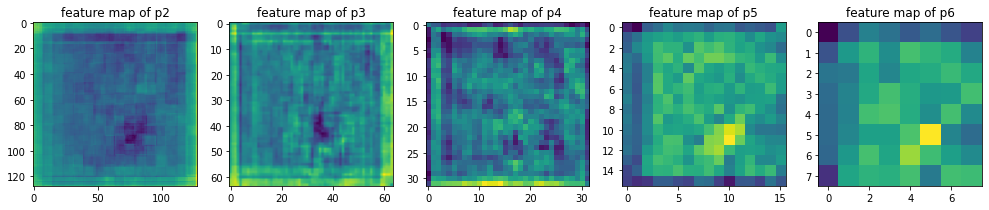

In [ ]:
# get local maps
local_maps = localisation(X, fast_rcnn)

In [ ]:
# upsampling 
cam = upsampling(0, local_maps, upsampling_mode='nearest')

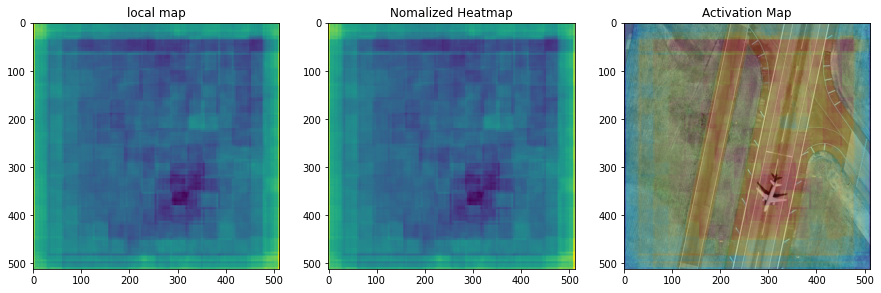

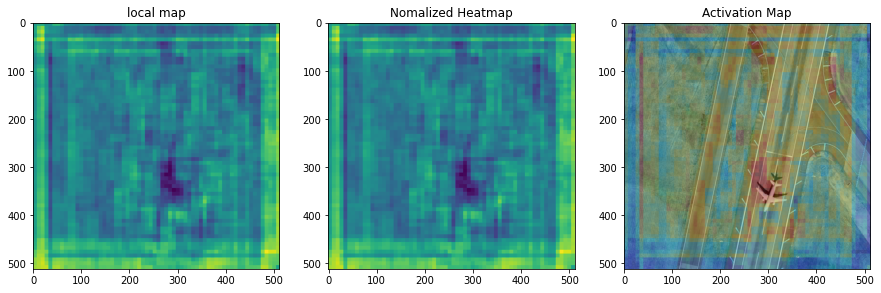

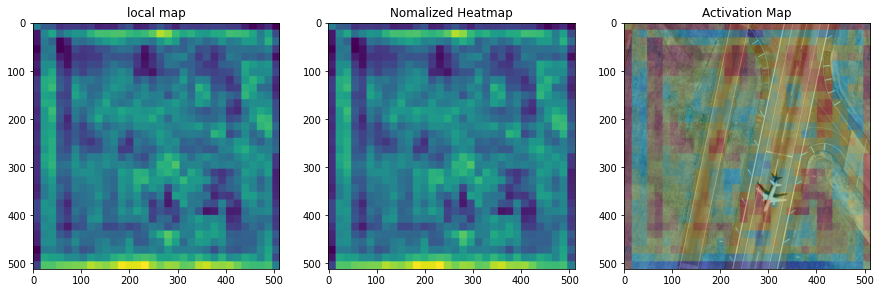

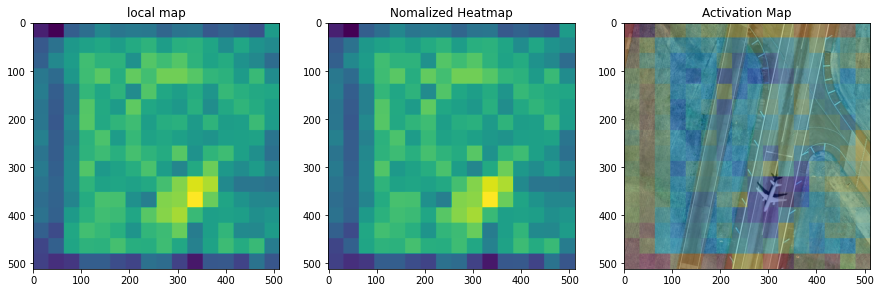

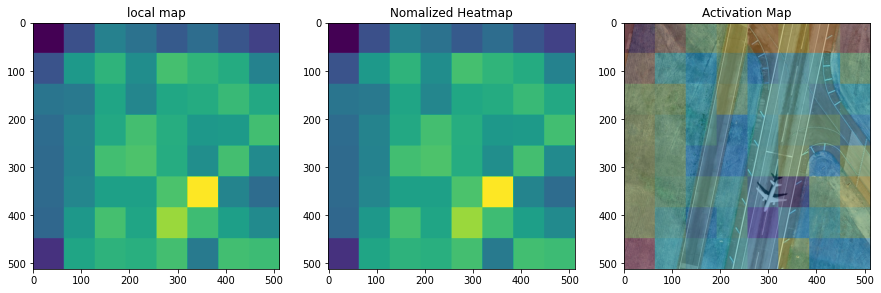

In [ ]:
# plot CAM 
for i in range(5):
    cam = upsampling(i, local_maps, upsampling_mode='nearest')
    cam = cam[0][0]
    (heatmap, output) = overlay_heatmap(cam, im, alpha=0.75)

# To Do

1. Inference using test set. Get the false predictions.
2. Which outputs need to be saved?
3. What are the most efficient way of studying the output Activation map?
It is almost impossible to read them one by one, so how to classify and study them?
